# Know Your Seattle - Analysis of Seattle Airbnb data

The goal of this project is to analyse Airbnb open source Seattle dataset *https://www.kaggle.com/airbnb/seattle* and extract insights out of it using Cross Industry Standard Process for Data Mining or ***CRISP-DM*** methodology.


CRISP-DM has following steps:
* Business Understanding
* Data Understanding
* Prepare Data
* Data Modeling
* Evaluation


## Step1: Business Understanding
Any accommodation domain always involves two parties, an owner and a tenant/visitor.As a visitor/tenant we may have following questions in my mind:
* Which is the busiest season in Seattle ?
* Does the accommodation rate varies with the season ?

As an owner, we may be considering:
* What are the parameters on which price of an accommodation depends ?

So  in this project, we will try to cover both the perspective by answering the above questions.

In [211]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import AllTogether as t
import seaborn as sns
from datetime import datetime
%matplotlib inline


## Step2: Data Understanding

In [212]:
# read calendar data
df_calendar = pd.read_csv('./calendar.csv')
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [213]:
# basic analysis
print('columns: \n', df_calendar.columns)
print('total rows: ',df_calendar.shape[0])
print('total columns: ',df_calendar.shape[1])
print('column types: \n', df_calendar.dtypes)

columns: 
 Index(['listing_id', 'date', 'available', 'price'], dtype='object')
total rows:  1393570
total columns:  4
column types: 
 listing_id     int64
date          object
available     object
price         object
dtype: object


***calendar*** dataset has four columns *Id, Date, Available & Price*. Total number of listings/accommodations are 3818 and each of them includes availability info (true/false) for complete 365 days. The most expensive listing stands at `$1650` and least expensive is at `$10`. The average cost of listing is `$138` and the standard deviation is `$105` in Seattle.

In [214]:
df_listings = pd.read_csv('./listings.csv')
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [215]:
df_listings['review_scores_rating'].describe()

count    3171.000000
mean       94.539262
std         6.606083
min        20.000000
25%        93.000000
50%        96.000000
75%        99.000000
max       100.000000
Name: review_scores_rating, dtype: float64

***listings*** dataset has a total of 92 columns storing all the info related to 3818 accommodations such as owner, features, location, neighborhood, reviews etc. The average current price is `$128`, average security deposit is `$288`, average cleaning fee is `$68`and average extra people cost is `$11` in Seattle. There are hosts as old as since 10 Nov 2008 to as new as 03 Jan 2016. Around 778 or 20% owners got ***super host*** rating. Overall, average rating for an owner in Seattle is 94 out of 100 which is quite good.

## Step3: Prepare Data

In [216]:
def process_price(df, col):
    """Converts the price values that are string with special characters to numbers."""
    
    df[col] = df[col].replace('[$,]','', regex=True).astype(float)

In [217]:
# remove unwanted characters from price and convert it to numeric
process_price(df_calendar, 'price')

In [218]:
df_calendar['price'].head()

0    85.0
1    85.0
2     NaN
3     NaN
4     NaN
Name: price, dtype: float64

In [219]:
df_calendar['price'].describe()

count    934542.000000
mean        137.944859
std         105.062870
min          10.000000
25%          75.000000
50%         109.000000
75%         160.000000
max        1650.000000
Name: price, dtype: float64

In [220]:
def process_date(df, col):
    """Converts the date that are string to date_time values."""
    
    df[col] = pd.to_datetime(df[col], format='%Y-%m-%d')

In [221]:
# convert string dates to date_time values
process_date(df_calendar, 'date')

In [222]:
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,85.0
1,241032,2016-01-05,t,85.0
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [223]:
# determine seasons, ref: https://www.timeanddate.com/calendar/aboutseasons.html
seasons = {
    1: 'winter',
    2: 'winter',
    3: 'spring',
    4: 'spring',
    5: 'spring',
    6: 'summer',
    7: 'summer',
    8: 'summer',
    9: 'fall',
    10: 'fall',
    11: 'fall',
    12: 'winter'
}

In [224]:
# add season info in dataframe
df_calendar['date_season'] = df_calendar['date'].dt.month.apply(lambda x: seasons[x])

In [225]:
df_calendar['date_season'].value_counts()

spring    351256
summer    351256
fall      347438
winter    343620
Name: date_season, dtype: int64

***NOTE:*** Here we see number of records in winter is less than summer. This difference has an impact in our final result.

In [226]:
df_calendar['available'].value_counts()

t    934542
f    459028
Name: available, dtype: int64

In [227]:
def process_boolean(df, col):
    """Converts boolean true to 1 and boolean false to 0."""
    
    df[col] = df[col].replace({'t': 1, 'f': 0})

In [228]:
# convert boolean string to boolean int
process_boolean(df_calendar, 'available')

In [229]:
df_calendar['available'].value_counts()

1    934542
0    459028
Name: available, dtype: int64

In [230]:
def plot_data(df):
    """Plots the data in dataframe as a bar graph."""
    
    df.plot(kind = 'barh')

In [231]:
# find availability per season, the lower the busier
availability_per_season = df_calendar.groupby(df_calendar['date_season'])['available'].sum().sort_values()

In [232]:
# find price per season, more pricy means more demanding
price_per_season = df_calendar.groupby(df_calendar['date_season'])['price'].mean().sort_values(ascending = False)

### Data preprocessing of listings dataset

In [233]:
# identify missing values of more than 75%
set(df_listings.columns[df_listings.isnull().mean() > 0.95])

{'license', 'square_feet'}

I have chosen 95% as the threshold for missing count as such columns will not have any weightage in our prediction model

In [234]:
# delete the most missing values columns
df_listings = df_listings.drop(columns = ['license', 'square_feet'])

In [235]:
df_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

The following columns are decided as unimportant because they would not help in prediction modeling:
* unique & random id's and url's etc. as strings
* string data such as notes, summary, description, neighborhood overview etc.
* redundant data such as city, state, country code etc.
* complex parameters such as neighborhood or amenities as they would complicate our model
* skewed data such as smart_location, has_availability etc.

In [236]:
df_listings['has_availability'].value_counts()

t    3818
Name: has_availability, dtype: int64

In [237]:
# columns that would not help in our modeling
unimportant_columns = ['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description',
                     'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 
                      'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name',
                      'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
                      'host_verifications', 'street', 'neighbourhood', 'city', 'state', 'zipcode', 'country_code', 
                      'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'amenities','host_listings_count', 
                       'market', 'smart_location', 'country', 'calendar_updated', 'has_availability', 
                       'calendar_last_scraped', 'first_review', 'last_review', 'jurisdiction_names', 
                       'calculated_host_listings_count']

In [238]:
df_listings = df_listings.drop(columns = unimportant_columns)

In [239]:
df_listings.head()

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,2011-08-11,within a few hours,96%,100%,f,3.0,t,t,47.636289,-122.371025,...,10.0,10.0,9.0,10.0,f,f,moderate,f,f,4.07
1,2013-02-21,within an hour,98%,100%,t,6.0,t,t,47.639123,-122.365666,...,10.0,10.0,10.0,10.0,f,f,strict,t,t,1.48
2,2014-06-12,within a few hours,67%,100%,f,2.0,t,t,47.629724,-122.369483,...,10.0,10.0,10.0,10.0,f,f,strict,f,f,1.15
3,2013-11-06,NaN,NaN,NaN,f,1.0,t,t,47.638473,-122.369279,...,NaN,NaN,NaN,NaN,f,f,flexible,f,f,NaN
4,2011-11-29,within an hour,100%,NaN,f,2.0,t,t,47.632918,-122.372471,...,10.0,10.0,9.0,9.0,f,f,strict,f,f,0.89


In [240]:
print(df_listings.shape[0])
print(df_listings.shape[1])

3818
45


In [241]:
# identify price columns, they have special characters
price_columns = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']

In [242]:
# remove unwanted characters from price and convert it to numeric
for price in price_columns:
    process_price(df_listings, price)

In [243]:
for price in price_columns:
    print('col: {}, average: {}'.format(price, df_listings[price].mean()))

col: price, average: 127.97616553169199
col: weekly_price, average: 788.4818317570931
col: monthly_price, average: 2613.336189848385
col: security_deposit, average: 287.61039657020365
col: cleaning_fee, average: 61.71090387374462
col: extra_people, average: 10.667627029858565


In [244]:
boolean_columns = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'is_location_exact',
                  'instant_bookable', 'require_guest_profile_picture', 'require_guest_phone_verification']

In [245]:
df_listings['host_is_superhost'].value_counts()

f    3038
t     778
Name: host_is_superhost, dtype: int64

In [246]:
df_listings['requires_license'].value_counts()

f    3818
Name: requires_license, dtype: int64

In [247]:
# remove column whose data is skewed
df_listings = df_listings.drop(columns = ['requires_license'])

In [248]:
# convert boolean string to boolean int
for boolean_column in boolean_columns:
    process_boolean(df_listings, boolean_column)

In [249]:
df_listings['host_acceptance_rate'].value_counts()

100%    3044
0%         1
Name: host_acceptance_rate, dtype: int64

In [250]:
# remove column whose data is skewed
df_listings = df_listings.drop(columns = ['host_acceptance_rate'])

In [251]:
def process_percentage(df, col):
    """Converts percentage values to numbers."""
    
    df[col] = df[col].replace('%', '', regex=True).astype(float)

In [252]:
# remove unwanted characters from percentage column and convert it to numeric
process_percentage(df_listings, 'host_response_rate')

In [253]:
# convert string dates to date_time values
process_date(df_listings, 'host_since')

In [254]:
df_listings['host_since'].describe()

count                    3816
unique                   1380
top       2013-08-30 00:00:00
freq                       51
first     2008-11-10 00:00:00
last      2016-01-03 00:00:00
Name: host_since, dtype: object

In [255]:
df_listings['host_since'].tail()

3813   2015-04-13
3814   2015-10-14
3815   2015-12-30
3816   2015-01-03
3817   2014-04-25
Name: host_since, dtype: datetime64[ns]

In [256]:
def convert_date_to_number(df, col, first_day):
    """Converts date to number of days since first day."""
    
    df[col] = df[col].apply(lambda date: (first_day - date).days)

In [257]:
# find first day of the data, then host_since (in days) = (first_day - host_since).days
first_day = pd.to_datetime('2016-01-04')
print(first_day)

2016-01-04 00:00:00


In [258]:
# convert date_time values to number of days numeric
convert_date_to_number(df_listings, 'host_since', first_day)

In [259]:
df_listings['host_since'].tail()

3813    266.0
3814     82.0
3815      5.0
3816    366.0
3817    619.0
Name: host_since, dtype: float64

In [260]:
df_listings.columns

Index(['host_since', 'host_response_time', 'host_response_rate',
       'host_is_superhost', 'host_total_listings_count',
       'host_has_profile_pic', 'host_identity_verified', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'reviews_per_month'],
      dtype='object')

Drop any row that does not have a value for response column ***price***

In [261]:
# drop any row where price is NAN
df_listings = df_listings.dropna(subset=['price'], axis=0)

In [262]:
# identify numeric columns
numeric_columns = df_listings.select_dtypes(include=['float', 'int']).columns
numeric_columns

Index(['host_since', 'host_response_rate', 'host_is_superhost',
       'host_total_listings_count', 'host_has_profile_pic',
       'host_identity_verified', 'latitude', 'longitude', 'is_location_exact',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price',
       'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'reviews_per_month'],
      dtype='object')

These numeric columns are important for our prediction. As sklearn's fit() method does not work with NANs, we have to impute the NANs. As these are numbers, mean of the colums is appropriate for imputing NANs. 

In [263]:
# fill missing numeric column with mean of the column
for col in numeric_columns:
        df_listings[col].fillna((df_listings[col].mean()), inplace=True)

In [264]:
df_listings.head()

,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,reviews_per_month
0,1607.0,within a few hours,96.000000,0.0,3.0,1.0,1.0,47.636289,-122.371025,1,...,10.000000,10.000000,10.000000,9.000000,10.000000,0,moderate,0,0,4.070000
1,1047.0,within an hour,98.000000,1.0,6.0,1.0,1.0,47.639123,-122.365666,1,...,10.000000,10.000000,10.000000,10.000000,10.000000,0,strict,1,1,1.480000
2,571.0,within a few hours,67.000000,0.0,2.0,1.0,1.0,47.629724,-122.369483,1,...,10.000000,10.000000,10.000000,10.000000,10.000000,0,strict,0,0,1.150000
3,789.0,NaN,94.886798,0.0,1.0,1.0,1.0,47.638473,-122.369279,1,...,9.556398,9.786709,9.809599,9.608916,9.452245,0,flexible,0,0,2.078919
4,1497.0,within an hour,100.000000,0.0,2.0,1.0,1.0,47.632918,-122.372471,1,...,9.000000,10.000000,10.000000,9.000000,9.000000,0,strict,0,0,0.890000


In [265]:
# identify categorical columns
categorical_columns = df_listings.select_dtypes(include=['object']).columns
categorical_columns

Index(['host_response_time', 'property_type', 'room_type', 'bed_type',
       'cancellation_policy'],
      dtype='object')

As categorical values are important for our modeling step, instead of dropping we will encode them with 1's and 0's. One advantage of this is with linear modeling, it's easy to interpret weights on these categorical values. Also, since the number of new dummy-columns created is far less than the number of rows, thus, we are safe from its scalability issues. We must also be aware that NANs in these columns would be encoded with 0 and this may impact our result.

In [266]:
# fill missing categorical columns with dummy data
for col in  categorical_columns:
        df_listings = pd.concat([df_listings.drop(col, axis=1), pd.get_dummies(df_listings[col], prefix=col, prefix_sep='_', drop_first=True)], axis=1)

In [267]:
df_listings.head()

,host_since,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,latitude,longitude,is_location_exact,accommodates,...,property_type_Treehouse,property_type_Yurt,room_type_Private room,room_type_Shared room,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,cancellation_policy_moderate,cancellation_policy_strict
0,1607.0,96.000000,0.0,3.0,1.0,1.0,47.636289,-122.371025,1,4,...,0,0,0,0,0,0,0,1,1,0
1,1047.0,98.000000,1.0,6.0,1.0,1.0,47.639123,-122.365666,1,4,...,0,0,0,0,0,0,0,1,0,1
2,571.0,67.000000,0.0,2.0,1.0,1.0,47.629724,-122.369483,1,11,...,0,0,0,0,0,0,0,1,0,1
3,789.0,94.886798,0.0,1.0,1.0,1.0,47.638473,-122.369279,1,3,...,0,0,0,0,0,0,0,1,0,0
4,1497.0,100.000000,0.0,2.0,1.0,1.0,47.632918,-122.372471,1,6,...,0,0,0,0,0,0,0,1,0,1


## Step4: Data Modeling

In [268]:
y = df_listings['price']
# remove the response column
df_listings = df_listings.drop(['price'], axis=1)
X = df_listings

In [269]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)
print('Training sample: {}'.format(X_train.shape[0]))
print('Testing sample: {}'.format(X_test.shape[0]))

# instantiate model
rf_model = RandomForestRegressor()
# fit training data
rf_model.fit(X_train, y_train)
# predict price on training and test data
y_test_preds = rf_model.predict(X_test)
y_train_preds = rf_model.predict(X_train)

train_score = r2_score(y_train, y_train_preds)
print('train_score: {}'.format(train_score))
test_score = r2_score(y_test, y_test_preds)
print('test_score: {}'.format(test_score))

feature_importances = pd.Series(rf_model.feature_importances_, index=df_listings.columns)

Training sample: 2672
Testing sample: 1146
train_score: 0.9251969660428926
test_score: 0.6700559978786749


## Step5: Evaluation

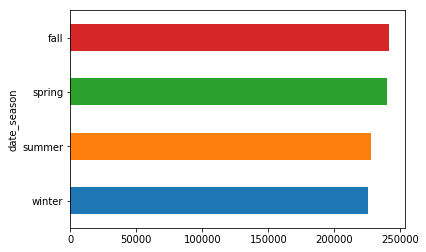

In [270]:
plot_data(availability_per_season)

The plot above answers our first question. Summer shows a low count as most of the tourists prefer this season 
leading to low availability. Surprisingly, winter was the lowest, but this can also be attributed to the reason that 
number of days during in winter (90) in this dataset were lesser than the number of days in summer (92). 
Thus, considering the case of equal number of days, ***we can conclude that the Summer is the busiest season***.

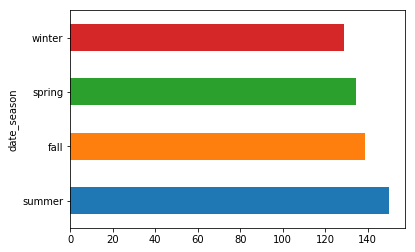

In [271]:
plot_data(price_per_season)

The plot above answers our second question. We can clearly conclude that ***price does vary as per the season*** and 
busy season (as summer) means high prices too.

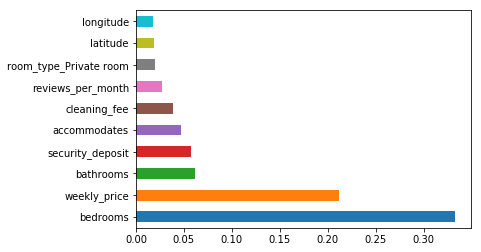

In [272]:
plot_data(feature_importances.nlargest(10))

The plot above answers our third question. Clearly, ***number of bedrooms** came out to be most important parameter followed by ***weekly_price***. We can classify top 10 features into general categories such as features, prices, reviews and location. 

***Discussion:*** I have tried to show here a simple procedure to do analysis on Airbnb Seattle dataset. There is still a lot of areas where we could improve such as including complex features in our prediction such as amenities and neighborhood or using better linear model. But to keep this project short and simple, we have ignored them from our analysis.